In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
graph=nx.read_edgelist('graph.txt',nodetype=int)

In [3]:
print(type(graph))

<class 'networkx.classes.graph.Graph'>


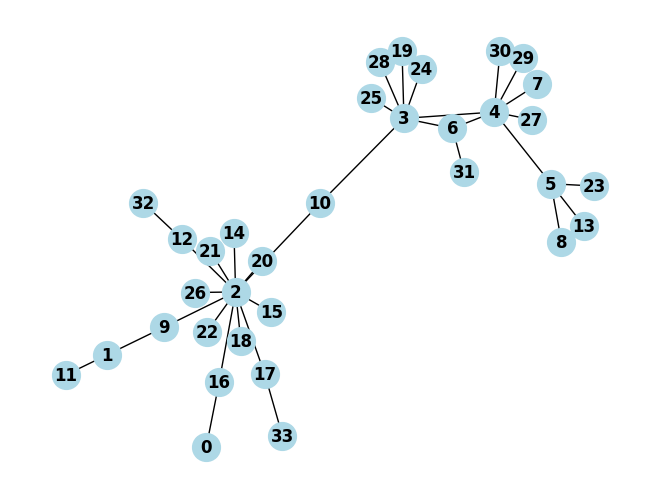

In [4]:
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=400, font_size=12, font_color='black', font_weight='bold')
plt.show()

In [5]:
def findNeighborEdges(graph,edge):
    neighborEdges = [(edge[0],neighbor) for neighbor in graph.neighbors(edge[0])] + [(edge[1],neighbor) for neighbor in graph.neighbors(edge[1])]
    return [i for i in neighborEdges if (i!=edge and i!=edge[::-1])]

# def initializePopulation(graph):

In [6]:
class Individual:
    def __init__(self, sets):
        self.size = sum(len(s) for s in sets)
        self.loci = [(None, None) for _ in range(self.size)]
        self.gene = [(None, None) for _ in range(self.size)]
        self._populate_individual(sets)

    def _populate_individual(self, sets):
        current_position = 0
        for set in sets:
            visited = {t: 0 for t in set}
            random_set = list(set)
            random.shuffle(random_set)
            for cur_tuple in set:
                value_assigned = False
                
                for other_tuple in random_set:
                    if visited[other_tuple] or other_tuple == cur_tuple:
                        continue
                    if self.adjacent(cur_tuple, other_tuple):
                        self.loci[current_position] = cur_tuple
                        self.gene[current_position] = other_tuple
                        current_position += 1
                        value_assigned = True
                        visited[other_tuple] = 1
                        break

                if not value_assigned:
                    for t in random_set:
                        if(not visited[t]): other_tuple=t 
                    self.loci[current_position] = cur_tuple
                    self.gene[current_position] = other_tuple
                    visited[cur_tuple] = 1
                    current_position += 1

    def adjacent(self, t1, t2):
        if t1[0] == t2[0] or t1[0] == t2[1] or t1[1] == t2[0] or t1[1] == t2[1]:
            return True
        return False

    def decode(self):
        labels = {l: 0 for l in self.loci}

        c=1
        for i in range(self.size):
            if labels[self.loci[i]] == 0 and labels[self.gene[i]] == 0:
                labels[self.loci[i]]=c
                labels[self.gene[i]]=c
                c+=1
            elif labels[self.loci[i]] == 0:
                labels[self.loci[i]] = labels[self.gene[i]]
            elif labels[self.gene[i]] == 0:
                labels[self.gene[i]] = labels[self.loci[i]]

        value_to_keys = {}
        for key, value in labels.items():
            if value in value_to_keys:
                value_to_keys[value].add(key)
            else:
                value_to_keys[value] = {key}
        return list(value_to_keys.values())

    def __str__(self):
        loci_str = ', '.join(map(str, self.loci))
        gene_str = ', '.join(map(str, self.gene))
        return f"Loci: [{loci_str}]\nGene: [{gene_str}]"

In [7]:
def most_frequent_label(labels, graph, v):
    neighbors_of_v = list(graph.neighbors(v))
    max_value = max(labels[key] for key in neighbors_of_v)
    max_keys = [key for key in neighbors_of_v if labels[key] == max_value]
    return random.choice(max_keys)

def node_to_edge_community(labels,graph):
    communities={}
    for edge in graph.edges():
        u, v = edge
        if labels[u] == labels[v]:
            community=labels[u]
        else : 
            community = random.choice([labels[u],labels[v]])
        if community in communities:
            communities[community].add(edge)
        else : communities[community] ={edge}
    return [value_set for value_set in communities.values()]

def label_propagation(graph):
    stop = False
    labels = {node: node for node in graph.nodes()}
    while not stop:
        stop = True
        shuffled_nodes = list(graph.nodes())
        random.shuffle(shuffled_nodes)
        for v in shuffled_nodes:
            current = labels[v]
            labels[v] = most_frequent_label(labels, graph, v)

            if labels[v] != current:
                stop = False

    communities=node_to_edge_community(labels,graph)
    individual = Individual(communities)
    return individual
    
    

label_propagation(graph)

In [24]:
#local expansion
def natural_community(graph, seed):
    nodes = list(graph.neighbors(seed)) + [seed]
    res = graph.subgraph(nodes)
    return res

def local_expansion(graph,given_nodes):
    communities = {}
    visited = {node: 0 for node in given_nodes}
    labels = {node: node for node in graph.nodes()}
    for seed in given_nodes:
        if visited[seed]:
            continue
        visited[seed] = 1
        nat_com = natural_community(graph, seed)
        for node in list(nat_com.nodes()):
            labels[node] = seed
    communities = node_to_edge_community(labels, graph)
    
    individual = Individual(communities)
    return individual

def local_expansion_random(graph):
    shuffled_nodes = list(graph.nodes())
    random.shuffle(shuffled_nodes)
    return local_expansion(graph,shuffled_nodes)

def local_expansion_by_degree(graph):
    degrees=dict(graph.degree())
    sorted_nodes = sorted(degrees, key = lambda x : degrees[x], reverse = True)
    return local_expansion(graph,sorted_nodes)

def local_expansion_by_eigenvector_centrality(graph):
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
    sorted_nodes = [node for node, centrality in sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)]
    return local_expansion(graph,sorted_nodes)


[2,
 10,
 3,
 9,
 16,
 12,
 17,
 14,
 15,
 18,
 20,
 21,
 22,
 26,
 4,
 6,
 1,
 19,
 24,
 25,
 28,
 5,
 0,
 32,
 33,
 7,
 27,
 29,
 30,
 31,
 11,
 8,
 13,
 23]

In [16]:
def initializePopulation(graph):
    tree=[]
    for i in range(13):
        subtree=[]
        for j in range(7):
            initializers=[local_expansion,label_propagation]
            chosen_function = random.choice(initializers)
            subtree.append(chosen_function(graph))
        tree.append(subtree)
    return tree
initializePopulation(graph)

7


In [ ]:
#Link Partition Density
def fitness(individual):
    communities = individual.decode();
    ans=0
    total_edge=0
    for community in communities:
        nodes=set()
        for edge in community:
            nodes.add(edge[0])
            nodes.add(edge[1])
        n = len(nodes)
        m = len(community)
        total_edge+=m
        if(n < 3):
            continue
        ans += (m*((m-(n-1))/((n-1)*(n-2))))
    ans *= (len(communities)/total_edge)
    return ans

1 {0, 16}
7 {2, 14, 16, 17, 18, 20, 22, 26}
2 {1, 11, 9}
1 {9, 2}
2 {3, 2, 10}
2 {32, 2, 12}
1 {2, 15}
1 {2, 21}
4 {3, 6, 19, 24, 25}
7 {3, 4, 5, 7, 8, 27, 29, 30}
1 {3, 28}
2 {4, 6, 31}
1 {13, 5}
1 {5, 23}
1 {17, 33}


0.0

In [ ]:
def m_link(adj, lsp=0.5, cp=0.5, mp=0.5):
    treePopulation = initializePopulation(adj)
    evaluate(treePopulation)

    while termination :
        for a in treePopulation:
            parent1 = selectIndividualFrom(a)
            
            if notLostDiversity():
                parent2 = closeSelect(a)
            else:
                parent2 = farSelect(a)
            
            offspring = crossover(parent1, parent2, cp)
            mutate(offspring)

            if (random.uniform(0,1) < lsp):
                localSearch(offspring)
            
            updatePopulation(offspring)
            
    overlappingCommunities = postProcessing(getBest(treePopulation))